# Batch Effect Calibration Analysis

In this notebook, we will show that CarDEC largely corrects for batch effects when denoising gene expression data. We also examine the denoised/batch corrected counts for other methods including Scanorama, DCA, scVI, and MNN.

Before running this notebook, please run the following scripts/notebooks:

1. "../Evaluations of Competing Methods/MNN_Pancreas.R"
2. "../Evaluations of Competing Methods/Competing Methods Pancreas.ipynb"
3. "CarDEC Pancreas.ipynb"

## Analysis Preparation

First, let's import key packages, prepare useful functions, and read the data in.

In [1]:
"""Broadly useful python packages"""
import pandas as pd
import os
import numpy as np
from copy import deepcopy
from math import log
import pickle
from math import floor, log
from shutil import copytree
from PIL import Image
"""Machine learning and single cell packages"""
import matplotlib.pyplot as pyplot
import scanpy as sc
from anndata import AnnData
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn import metrics
from sklearn.metrics import adjusted_rand_score as ari, normalized_mutual_info_score as nmi
import torch

"""CarDEC Package"""
from CarDEC import CarDEC_API

"""import scVI Package"""
import scvi
from scvi.model import SCVI

%matplotlib inline

In [2]:
"""Miscellaneous useful functions"""

def read_pancreas(path, cache=True):
    """A function to read and preprocess the pancreas data"""
    pathlist = os.listdir(path)
    adata = sc.read(os.path.join(path, pathlist[0]))
    
    for i in range(1,len(pathlist)):
        adata = adata.concatenate(sc.read(os.path.join(path, pathlist[i])))

    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=30)
    mito_genes = adata.var_names.str.startswith('mt-')
    
    notmito_genes = [not x for x in mito_genes]
    adata = adata[:,notmito_genes]
    
    return(adata)

def convert_string_to_encoding(string, vector_key):
    """A function to convert a string to a numeric encoding"""
    return np.argwhere(vector_key == string)[0][0]

def convert_vector_to_encoding(vector, printkey = False):
    """A function to convert a vector of strings to a dense numeric encoding"""
    vector_key = np.unique(vector)
    if printkey:
        print(pd.Series(vector_key))
    
    vector_strings = list(vector)
    vector_num = [convert_string_to_encoding(string, vector_key) for string in vector_strings]
    
    return vector_num

def purity_score(y_true, y_pred):
    """A function to compute cluster purity"""
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)

    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

def package_adata(matrix, inherit, index = None, normalize = True):
    packaged = AnnData(matrix)
    packaged.var.index = inherit.var.index
    packaged.obs["cell_type"] = list(inherit.obs['celltype'])
    packaged.obs["tech"] = list(inherit.obs['tech'])
    
    if normalize:
        sc.pp.normalize_total(packaged)
        sc.pp.log1p(packaged)
    
    if index is not None:
        packaged.obs.index = index
    
    return packaged

def create_subdataset(adata, type_):   
    sample = deepcopy(adata.X)
    celltype = adata.obs['cell_type'].values
    trimmed_batch = deepcopy(adata.obs["tech"])
    id_vector = [x == celltype_key[type_] for x in celltype]
    sample = sample[id_vector,]
    trimmed_batch = trimmed_batch[id_vector]
    return [sample, trimmed_batch, adata.var.index]

def find_resolution(adata_, n_clusters, random = 0): 
    adata = adata_.copy()
    obtained_clusters = -1
    iteration = 0
    resolutions = [0., 1000.]
    
    while obtained_clusters != n_clusters and iteration < 50:
        current_res = sum(resolutions)/2
        sc.tl.louvain(adata, resolution = current_res, random_state = random)
        labels = adata.obs['louvain']
        
        obtained_clusters = len(np.unique(labels))
        
        if obtained_clusters < n_clusters:
            resolutions[0] = current_res
        else:
            resolutions[1] = current_res
        
        iteration = iteration + 1
        
    return current_res

def build_dir(dir_path):
    subdirs = [dir_path]
    substring = dir_path

    while substring != '':
        splt_dir = os.path.split(substring)
        substring = splt_dir[0]
        subdirs.append(substring)
        
    subdirs.pop()
    subdirs = [x for x in subdirs if os.path.basename(x) != '..']

    n = len(subdirs)
    subdirs = [subdirs[n - 1 - x] for x in range(n)]
    
    for dir_ in subdirs:
        if not os.path.isdir(dir_):
            os.mkdir(dir_)

metrics_ = [ari, nmi, purity_score]

## Get the denoised counts

Next, let's load the weights for the CarDEC model and get the denoised output.

In [3]:
adata = read_pancreas("../Data/pancreas", cache=True)

CarDEC = CarDEC_API(adata, weights_dir = "Pancreas All/CarDEC_LVG Weights", batch_key = "tech", n_high_var = 2000)

CarDEC.build_model(n_clusters = 8)

CarDEC.make_inference()

CarDEC.model_counts()

denoised = deepcopy(CarDEC.dataset.layers["denoised counts"])
raw_counts = deepcopy(CarDEC.dataset.X)

Trying to set attribute `.var` of view, copying.
... storing 'tech' as categorical
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Pretrain weight index file detected, loading weights.
Pretrained high variance autoencoder weights initialized.

-----------------------CarDEC Architecture-----------------------

Model: "car_dec__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Sequential)         (None, 32)                260256    
_________________________________________________________________
decoder (Sequential)         (None, 2000)              262224    
_________________________________________________________________
encoderLVG (Sequential)      (1, 32)                   2463776   
_________________________________________________________________
decoderLVG (Sequential)      (1, 19215)                2487055   
_________________________________________________________________
clustering (ClusteringLayer) multiple                  256       
Total params: 5,473,567
Trainable params: 5,473,567
Non-trainable para

Next, let's load the weights for the Naive All Genes CarDEC model and get the denoised output.

Let's also load the denoised counts for DCA and scVI, and the batch corrected counts from MNN.

In [4]:
"""scVI Denoised Counts"""
anndataset = adata.copy()
scvi.data.setup_anndata(anndataset, batch_key = "tech")

vae = SCVI(anndataset, n_layers = 2)

filename = '../Evaluations of Competing Methods/scVI Results All/Pancreas/bestmodelnew'

if not os.path.exists(filename):
    vae.train(n_epochs = 200)
    vae.save(dir_path = filename)
        
vae = vae.load(anndataset, dir_path = filename)

latent = vae.get_latent_representation()
normalized_values = vae.get_normalized_expression(
    library_size=1e4, 
    transform_batch = "celseq", 
    n_samples=10, 
    return_mean=True,
)

scvi_denoised = AnnData(deepcopy(normalized_values))
scvi_denoised.obs = anndataset.obs

"""MNN Batch Corrected Counts"""

MNNdata = pd.read_csv("../Evaluations of Competing Methods/MNNcorrected/corrected_data_Pancreas.csv", index_col = 0)
meta_data = pd.read_csv("../Evaluations of Competing Methods/MNNcorrected/corrected_metadata_Pancreas.csv", index_col = 0)
MNNdata = MNNdata.T

MNN_denoised = AnnData(MNNdata)
MNN_denoised.obs = meta_data
adata = read_pancreas("../Data/pancreas", cache=True)

print("Verifying that cell type labels in output object are same as labels in MNN_denoised: computing ARI:")
print(ari(CarDEC.dataset.obs['celltype'], MNN_denoised.obs['celltype']))

MNN_denoised.obs['celltype'] = CarDEC.dataset.obs['celltype'].values

del MNNdata, meta_data, adata
anndataset.obs['tech'] = CarDEC.dataset.obs['tech']
MNN_denoised

INFO     Using batches from adata.obs["tech"]                                                
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 6321 cells, 21215 genes, 4        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


/Users/jlakkis/anaconda3/envs/cardec/lib/python3.7/site-packages/scvi/data/_anndata.py:790: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  logger_data_loc


WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered X field in anndata contains unnormalized count data.       


AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([1, 2], dtype='int64'), …


Verifying that cell type labels in output object are same as labels in MNN_denoised: computing ARI:
1.0


AnnData object with n_obs × n_vars = 6321 × 21215
    obs: 'celltype', 'tech', 'n_genes', 'percent_mito', 'n_counts'

Lastly, let's log normalize the counts for downstream analysis.

In [5]:
adata_d = package_adata(denoised, index = CarDEC.dataset.obs.index, inherit = CarDEC.dataset)
adata_r = package_adata(raw_counts, index = CarDEC.dataset.obs.index, inherit = CarDEC.dataset)
adata_scvi = package_adata(deepcopy(scvi_denoised), index = anndataset.obs.index, inherit = anndataset)

adata_mnn = MNN_denoised
adata_mnn.obs['cell_type'] = adata_mnn.obs['celltype']
adata_mnn.obs.index = CarDEC.dataset.obs.index

exceptions = ['DTX2P1-UPK3BP1.PMS2P11', 'HLA-F.AS1', 'PIGY-PYURF', 'C4A-C4B.C4B.2',
              'C4A-C4B.C4B.2.1', 'LUZP6-MTPN', 'GTF2IRD2-GTF2IRD2B',
              'STAG3L5P-PVRIG2P.PILRB', 'FAM226A-FAM226B', 'C1QTNF5-MFRP', 'SNORD116-2.SNORD116.6',
              'BOLA2-BOLA2B.LOC388242.LOC613038.SLX1A.SLX1A.SULT1A3.SLX1B.SLX1B.SULT1A4.SULT1A3.SULT1A4.1']
replacements = ['DTX2P1-UPK3BP1-PMS2P11', 'HLA-F-AS1', 'PIGY+PYURF', 'C4A+C4B+C4B-2', 'C4A+C4B+C4B-2.1',
               'LUZP6+MTPN', 'GTF2IRD2+GTF2IRD2B', 'STAG3L5P-PVRIG2P-PILRB', 'FAM226A+FAM226B', 'C1QTNF5+MFRP',
               'SNORD116-2+SNORD116-6',
               'BOLA2+BOLA2B+LOC388242+LOC613038+SLX1A+SLX1A-SULT1A3+SLX1B+SLX1B-SULT1A4+SULT1A3+SULT1A4.1']

def get_update(string):
    if string in adata_d.var.index:
        return string
    
    index_ = np.argwhere([x == string for x in exceptions])[0][0]
    return replacements[index_]

prob_indices = [x not in adata_d.var.index for x in adata_mnn.var.index]
index_vec = np.asarray(adata_mnn.var.index)
index_vec[prob_indices] = [x.replace('.', '-', 1) for x in list(index_vec[prob_indices])]
index_vec = [get_update(x) for x in index_vec]
adata_mnn.var.index = index_vec
adata_mnn.var.index[[x not in adata_d.var.index for x in adata_mnn.var.index]]

def sort_genes(adata):
    tmpindices_d = [x.replace("-", "") for x in adata_d.var.index]
    tmpindices_d = [x.replace("_", "") for x in tmpindices_d]
    tmpindices_nd = [x.replace("-", "") for x in adata.var.index]
    tmpindices_nd = [x.replace("_", "") for x in tmpindices_nd]
    assert len(np.unique(tmpindices_d)) == len(tmpindices_d)
    assert len(np.unique(tmpindices_nd)) == len(tmpindices_nd)
    indices = [np.where(np.asarray(tmpindices_nd) == x)[0][0] for x in tmpindices_d]
    adata = adata[:, indices]
    adata.var.index = adata_d.var.index
    return adata


adata_mnn.X[adata_mnn.X < 0.] = 0.

datasets = [adata_d, adata_r, adata_scvi, adata_mnn]
datasets = [sort_genes(ds) for ds in datasets]
names = ['CarDEC', "Raw", "scVI", "MNN"]

## Empirical CDF Analysis

In this section, our goal is to pick out some genes and examine their empirical cumulative distribution functions. We will pick out two cell types. Within each cell type we will plot one empirical CDF for each batch, and we will do this for both the raw counts and the denoised counts of each method.

First let's pick out some highly expressed genes, and some moderately expressed genes.

In [8]:
ranks = np.argsort(np.mean(adata_r.X, axis = 0)) #Get gene indices in order of increasing expression
n = ranks.shape[0]
ranks = [ranks[n - 1 - x] for x in list(range(n))] #Reverse order to rank cells in order of decreasing expression

#Compare raw ECDF to full ECDF

index_list = [0, 1, 2, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 3000, 3500, 4500, 5000, 6000, 7000, 8000, 9000, 10000] 
index_list = [ranks[x] for x in index_list]

gene_names = adata_r.var.index[index_list]

## Cell Type 3 (beta) Analysis

First, let's look at ECDFs of expression by batch within cell type 3: beta. Note that this is one of the rarer cell types in our dataset.

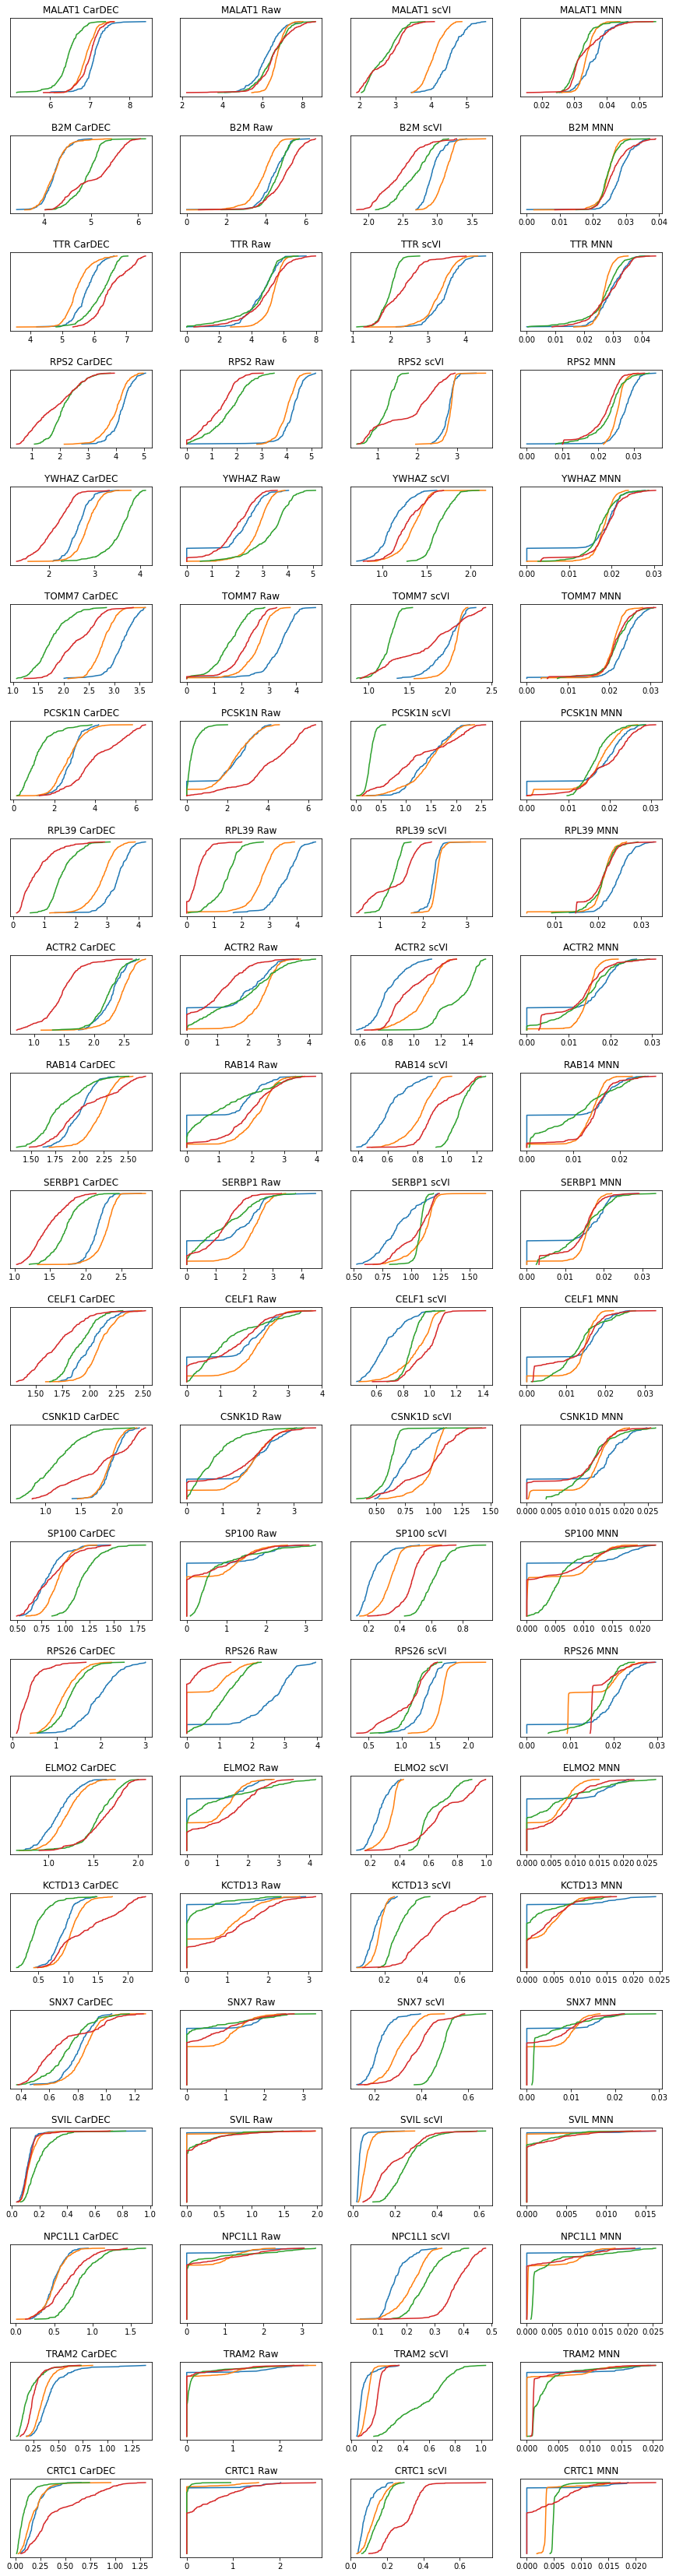

In [9]:
batch_key = np.unique(adata_r.obs['tech'])

subdatasets = [create_subdataset(ds, type_ = 3) for ds in datasets]

fig, axes = pyplot.subplots(len(index_list), 4, figsize = (15, 60))

index_count = 0
for gene in gene_names:

    method_count = 0
    for subdataset in subdatasets:
        sample, trimmed_batch, genes = subdataset
        index = np.argwhere([x in [gene] for x in list(genes)])[0][0]
        trimmed_counts = sample[:,index]
        
        for i in range(len(batch_key)):
            trimmed_counts_B = deepcopy(trimmed_counts)
            id_vector = [x == batch_key[i] for x in trimmed_batch]
            trimmed_counts_B = trimmed_counts_B[id_vector,]
            ecdf = ECDF(trimmed_counts_B)
            axes[index_count, method_count].plot(ecdf.x, ecdf.y)
            axes[index_count, method_count].set_yticks([])
            axes[index_count, method_count].title.set_text(gene + " " + names[method_count])
        
        method_count = method_count + 1
    
    index_count = index_count + 1
    
fig.subplots_adjust(hspace=.5)

## Cell Type 8 (gamma) Analysis

First, let's look at ECDFs of expression by batch within cell type 8: gamma.

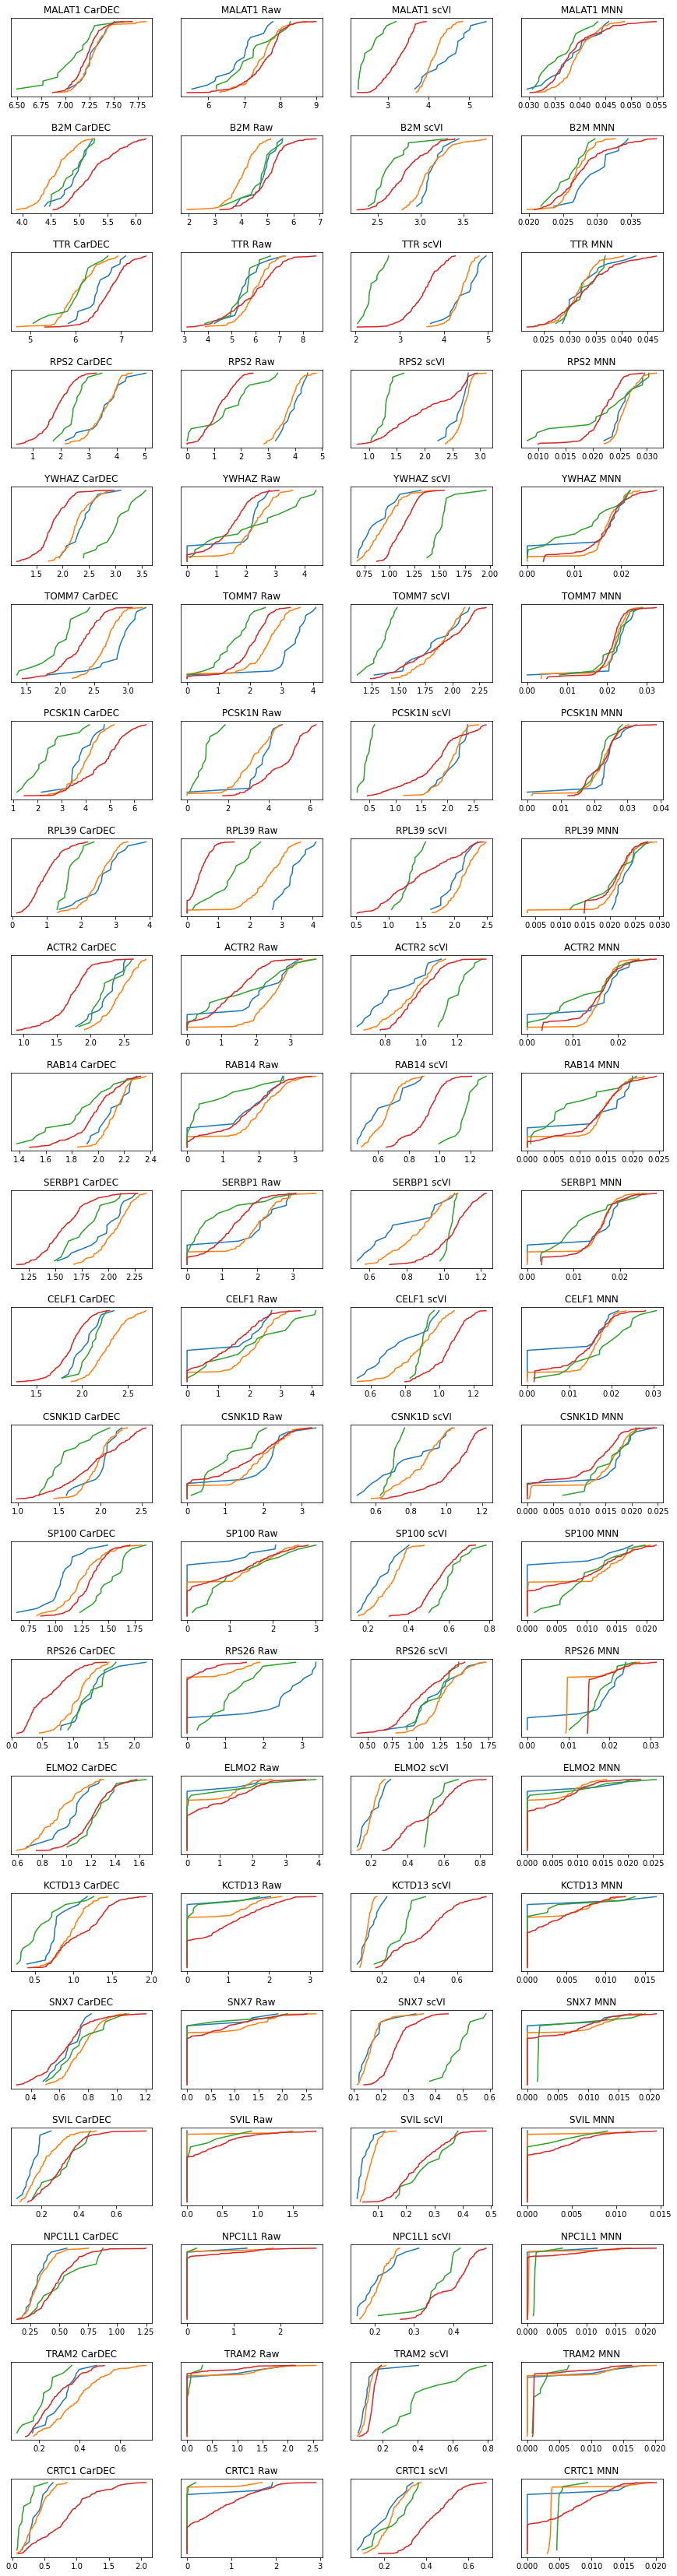

In [10]:
batch_key = np.unique(adata_r.obs['tech'])

subdatasets = [create_subdataset(ds, type_ = 8) for ds in datasets]

fig, axes = pyplot.subplots(len(index_list), 4, figsize = (15, 60))

index_count = 0
for gene in gene_names:

    method_count = 0
    for subdataset in subdatasets:
        sample, trimmed_batch, genes = subdataset
        index = np.argwhere([x in [gene] for x in list(genes)])[0][0]
        trimmed_counts = sample[:,index]

        for i in range(len(batch_key)):
            trimmed_counts_B = deepcopy(trimmed_counts)
            id_vector = [x == batch_key[i] for x in trimmed_batch]
            trimmed_counts_B = trimmed_counts_B[id_vector,]
            ecdf = ECDF(trimmed_counts_B)
            axes[index_count, method_count].plot(ecdf.x, ecdf.y)
            axes[index_count, method_count].set_yticks([])
            axes[index_count, method_count].title.set_text(gene + " " + names[method_count])
        
        method_count = method_count + 1
    
    index_count = index_count + 1
    
fig.subplots_adjust(hspace=.5)

## Coefficient of Variation Analysis

While fold change suffices for evaluating batch effect removal in the presence of only two batches, it is not enough to analyze batch effect removal when there are many batches, as fold change is a pairwise metric.

Let $c_{ajb} = \sum_{i \in S_{ab}} x_{ij} / \sum_{i \in S_{ab}} 1$ be the centroid of batch b in cell type a for gene j. Let $C_{aj} = \{c_{ajb}\}$ be the set of all batchwise centroids for cell type a, gene j. Then our metric is $$CV_{aj} = \frac{\sqrt{Var(C_{aj})}}{Mean(C_{aj}) + \gamma} $$

Here $\gamma$ is a very small constant included to mitigate computational instability. Note that coefficient of variation is computed genewise. To compare coefficients of variation between batches for all genes, we can plot a histogram of all of the genewise coefficients of variation before denoising and another histogram after. If our method corrects for batch effects, then we anticipate the coefficients of variation histogram to concentrate more around 0 after denoising.

Note that we may wish to compute a single $CV$ metric across all batches simultaneously. To do this, simply take a weighted average of $C_{aj}$ over index $a$. That is, compute the overall $CV$ as follows:

$$CV_{j} = \sum_a c(a)CV_{aj}$$

where $c(a)$ is defined as follows, and $n$ is the number of cells

$$c(a) = \sum_i I(a_i = a)/n$$

First, let's define the function we will use to compute coefficient of variation.

In [11]:
def centroid_dist(x, y):
    features = pd.DataFrame(x, index = range(x.shape[0]))
    Group = pd.Series(convert_vector_to_encoding(y), index = range(y.shape[0]), name="Group")
    Mergefeature = pd.concat([features, Group],axis=1)
    
    centroids = Mergefeature.groupby("Group").mean()
    result = (centroids.std(axis = 0).to_numpy())/abs(centroids.mean(axis = 0).to_numpy() + 10**(-12))
    
    return result

def centroid_dist_all(x, y, z):
    features = pd.DataFrame(x, index = range(x.shape[0]))
    Group = pd.Series(convert_vector_to_encoding(y), index = range(y.shape[0]), name="Group")
    Type = pd.Series(convert_vector_to_encoding(z), index = range(z.shape[0]), name="Type")
    n_cells = Type.value_counts().sort_index().to_numpy()

    Mergefeature = pd.concat([features, Group, Type], axis=1)
    
    df = Mergefeature.groupby(["Group", "Type"]).mean()
    df = df.groupby("Type").std()/(df.groupby("Type").mean() + 10**(-12)) * (n_cells/sum(n_cells))[:, None]
    return df[np.invert(np.isnan(df.to_numpy().sum(axis = 1)))].sum(axis = 0)

## Overall CV Analysis

done


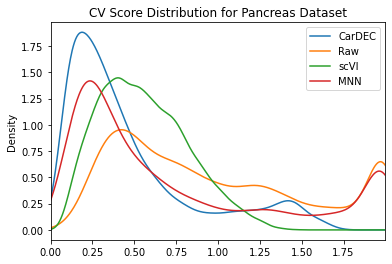

In [12]:
n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for dataset in datasets:    
    FPlist = centroid_dist_all(dataset.X, dataset.obs['tech'], dataset.obs['cell_type'])
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['MNN'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for Pancreas Dataset")
print("done")

"""Figure info for paper"""
figure_path = "../Figures/pancreas"
build_dir(figure_path)
path = os.path.join(figure_path, 'CVs')

myplot = myplot.get_figure()
myplot.savefig(path + '.png', dpi=300)
im = Image.open(path + '.png')
im.save(path + '.tiff')

In [14]:
hvg_bool = CarDEC.dataset.var['Variance Type'] == 'HVG'
lvg_bool = CarDEC.dataset.var['Variance Type'] == 'LVG'

Let's show the distribution of overall CVs for HVGs Only

done


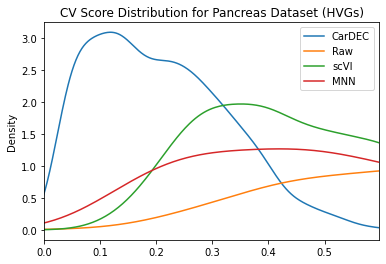

In [15]:
n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for dataset in datasets:  
    dataset = dataset[:, hvg_bool]
    FPlist = centroid_dist_all(dataset.X, dataset.obs['tech'], dataset.obs['cell_type'])
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for Pancreas Dataset (HVGs)")
print("done")

"""Figure info for paper"""
figure_path = "../Figures/pancreas_supplement"
build_dir(figure_path)
path = os.path.join(figure_path, 'CVs_HVG')

myplot = myplot.get_figure()
myplot.savefig(path + '.png', dpi=300)
im = Image.open(path + '.png')
im.save(path + '.tiff')

Let's show the distribution of overall CVs for LVGs Only

done


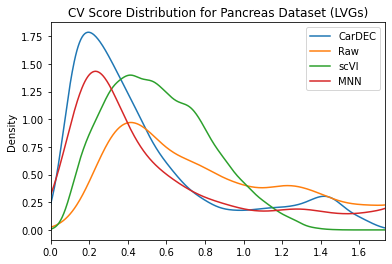

In [16]:
n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for dataset in datasets:  
    dataset = dataset[:, lvg_bool]
    FPlist = centroid_dist_all(dataset.X, dataset.obs['tech'], dataset.obs['cell_type'])
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = max(CVdata_['CarDEC'])
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for Pancreas Dataset (LVGs)")
print("done")

"""Figure info for paper"""
figure_path = "../Figures/pancreas_supplement"
build_dir(figure_path)
path = os.path.join(figure_path, 'CVs_LVG')

myplot = myplot.get_figure()
myplot.savefig(path + '.png', dpi=300)
im = Image.open(path + '.png')
im.save(path + '.tiff')

In the remainder of this notebook, we look at cell type distributions for individual cell types

## Cell Type 0 (acinar) CV Distribution Analysis

done


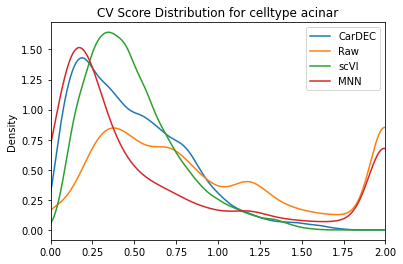

In [17]:
subdatasets = [create_subdataset(ds, type_ = 0) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = np.percentile((CVdata_['MNN']), 95)
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[0])
print("done")

## Cell Type 1 (activated_stellate) CV Distribution Analysis

done


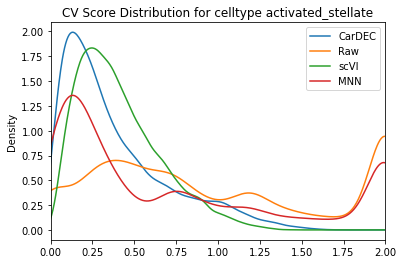

In [18]:
subdatasets = [create_subdataset(ds, type_ = 1) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = np.percentile((CVdata_['MNN']), 95)
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[1])
print("done")

## Cell Type 2 (alpha) CV Distribution Analysis

done


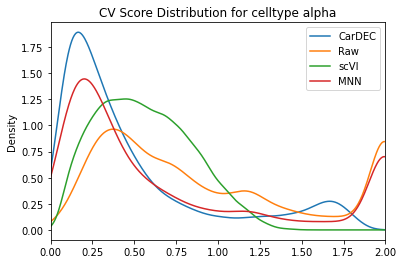

In [19]:
subdatasets = [create_subdataset(ds, type_ = 2) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = np.percentile((CVdata_['MNN']), 95)
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[2])
print("done")

## Cell Type 3 (beta) CV Distribution Analysis

done


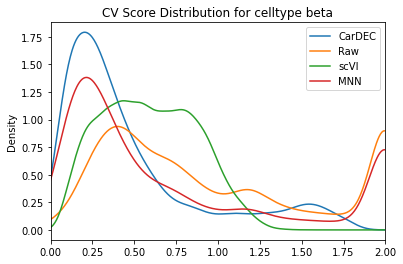

In [20]:
subdatasets = [create_subdataset(ds, type_ = 3) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = np.percentile((CVdata_['MNN']), 95)
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[3])
print("done")

## Cell Type 4 (delta) CV Distribution Analysis

done


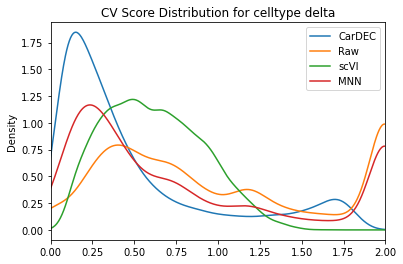

In [21]:
subdatasets = [create_subdataset(ds, type_ = 4) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = np.percentile((CVdata_['MNN']), 95)
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[4])
print("done")

## Cell Type 5 (ductal) CV Distribution Analysis

done


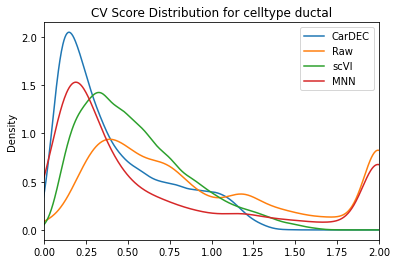

In [22]:
subdatasets = [create_subdataset(ds, type_ = 5) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = np.percentile((CVdata_['MNN']), 95)
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[5])
print("done")

## Cell Type 6 (endothelial) CV Distribution Analysis

done


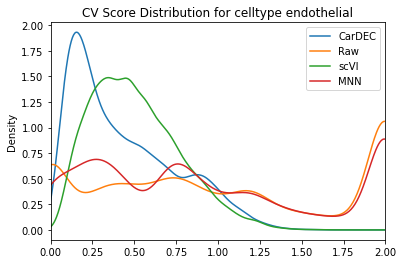

In [23]:
subdatasets = [create_subdataset(ds, type_ = 6) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = np.percentile((CVdata_['MNN']), 95)
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[6])
print("done")

## Cell Type 7 (epsilon) CV Distribution Analysis

done


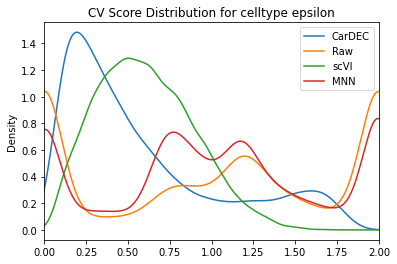

In [24]:
subdatasets = [create_subdataset(ds, type_ = 7) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = np.percentile((CVdata_['MNN']), 95)
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[7])
print("done")

## Cell Type 8 (gamma) CV Distribution Analysis

done


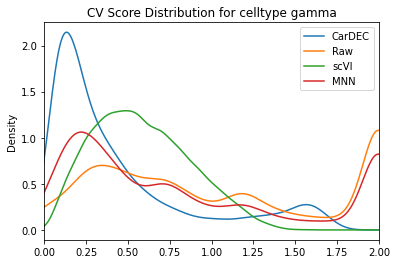

In [25]:
subdatasets = [create_subdataset(ds, type_ = 8) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = np.percentile((CVdata_['MNN']), 95)
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[8])
print("done")

## Cell Type 9 (macrophage) CV Distribution Analysis

done


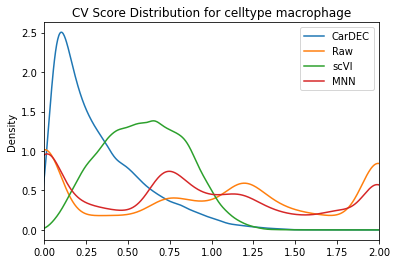

In [26]:
subdatasets = [create_subdataset(ds, type_ = 9) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = np.percentile((CVdata_['MNN']), 95)
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[9])
print("done")

## Cell Type 10 (mast) CV Distribution Analysis

done


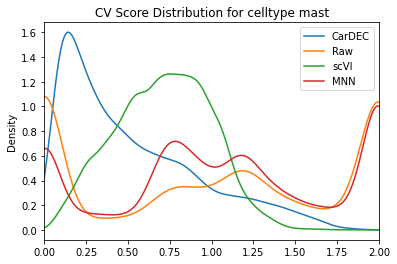

In [27]:
subdatasets = [create_subdataset(ds, type_ = 10) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = np.percentile((CVdata_['MNN']), 95)
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[10])
print("done")

## Cell Type 11 (quiescent_stellate) CV Distribution Analysis

done


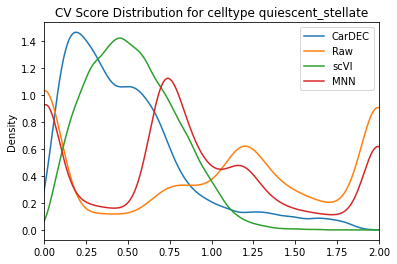

In [28]:
subdatasets = [create_subdataset(ds, type_ = 11) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = np.percentile((CVdata_['MNN']), 95)
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[11])
print("done")

## Cell Type 12 (schwann) CV Distribution Analysis

done


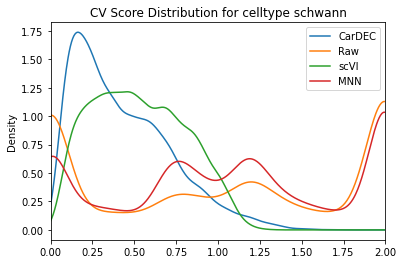

In [29]:
subdatasets = [create_subdataset(ds, type_ = 12) for ds in datasets]

n, p = adata_d.shape
CVdata_ = {}

method_count = 0
for subdataset in subdatasets:
    trimmed_counts, trimmed_batch, genes = subdataset
    
    FPlist = centroid_dist(trimmed_counts, trimmed_batch)
    
    CVdata_[names[method_count]] = FPlist
    method_count = method_count + 1
    
CVdata_ = pd.DataFrame(CVdata_)
myplot = CVdata_.plot.kde()
ubound = np.percentile((CVdata_['MNN']), 95)
myplot.set_xlim([0, ubound])
myplot.set_title("CV Score Distribution for celltype " + celltype_key[12])
print("done")